In [1]:
import json
import math
import os

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from scipy import stats
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import norm

import mre


## helper methods

In [42]:
def bhat(mtx1, mtx2):
    return -np.log(np.sum(np.sqrt(mtx1 * mtx2)))

# # code ported from https://github.com/sankalpg/Library_PythonNew
# EPS = np.finfo(np.float).resolution
# def sym_kld(mtx1, mtx2):
#     mtx1 = mtx1 + EPS
#     mtx2 = mtx2 + EPS
#     return mtx1 * np.log(mtx1/mtx2) + mtx2 * np.log(mtx2/mtx1)

In [2]:
def prepare_dataset(
    annotations,
    tdms_files,
    compression_exponent: float = None,  # no compression
    kernel_width: float = None # no smoothing
):
    NUM_BINS = int(1200 / mre.data.TimeDelayedMelodySurface.STEP_SIZE)
    
    num_samples = len(annotations.data)
    num_features = NUM_BINS * NUM_BINS

    # prepare features
    X_3d = np.zeros((NUM_BINS, NUM_BINS, num_samples))
    X_list = list()
    mbids = np.array([])
    for ii, tf in enumerate(tdms_files):
        tdms = mre.data.TDMSFeature.from_json(tf)
        if compression_exponent is not None:
            tdms.compression_exponent = compression_exponent
            tdms.compress()
        if kernel_width is not None:
            tdms.kernel_width = kernel_width
            tdms.smoothen()
        vals = tdms.embedding

        if vals.size != num_features:
            raise ValueError(
                "%s has %d bins instead of %d."
                % (tf, vals.size, num_features)
            )
        X_3d[:, :, ii] = vals
        X_list.append(vals)
        mbids = np.append(mbids, Path(tf).stem)

    y = annotations.data.set_index("mbid").loc[mbids].makam.values

    return {
        "X_3d": X_3d,
        "X_list": X_list,
        "y": y,
        "mbids": mbids,
        "files": tdms_files,
        "tdms_params": {
            "step_size": tdms.step_size,
            "compression_exponent": tdms.compression_exponent,
            "kernel_width": tdms.kernel_width,
            "time_delay_index": tdms.time_delay_index,
        }
    }


# Read data

## Annotations

In [3]:
annotations = mre.data.Annotation.from_mlflow()
display(annotations.head())

,dunya_uid,makam,mb_url,mbid,observations,tonic,verified
0,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,Acemasiran,http://musicbrainz.org/recording/00f1c6d9-c8ee...,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,,256.0,False
1,168f7c75-84fb-4316-99d7-acabadd3b2e6,Acemasiran,http://musicbrainz.org/recording/168f7c75-84fb...,168f7c75-84fb-4316-99d7-acabadd3b2e6,,115.2,False
2,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,Acemasiran,http://musicbrainz.org/recording/24f549dd-3fa4...,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,,232.5,False
3,407bb0b4-f19b-42ab-8c0a-9f1263126951,Acemasiran,http://musicbrainz.org/recording/407bb0b4-f19b...,407bb0b4-f19b-42ab-8c0a-9f1263126951,,233.5,False
4,443819eb-6092-420c-bd86-d946a0ad6555,Acemasiran,http://musicbrainz.org/recording/443819eb-6092...,443819eb-6092-420c-bd86-d946a0ad6555,,219.6,False


## Time Delayed Melody Surfaces

Below parameters seem optimal for the dataset. 

```
compression_exponent = 0.5
kernel_width = 12.5
time_delay_index = 1.0
```

In [4]:
OPTIMAL_TDMS_PARAMS = { 
    "time_delay_index":1.0,
    "compression_exponent":0.50,
    "kernel_width":12.5,
}

tdms_files = mre.data.TimeDelayedMelodySurface.from_mlflow(
    time_delay_index=OPTIMAL_TDMS_PARAMS["time_delay_index"],
    compression_exponent=None,  # used below
    kernel_width=None  # used below
)

dataset = prepare_dataset(
    annotations,
    tdms_files,
    compression_exponent=OPTIMAL_TDMS_PARAMS["compression_exponent"],
    kernel_width=OPTIMAL_TDMS_PARAMS["kernel_width"]
)
dataset.keys()

dict_keys(['X_3d', 'X_list', 'y', 'mbids', 'files', 'tdms_params'])

# Dendrogram

In [66]:
# this was defined much later (in cluster purity), moved here
LABEL_DICT = {
    'Acemasiran': 'Acemaşiran',          
    'Acemkurdi': 'Acemkürdi',          
    'Bestenigar': 'Bestenigar',          
    'Beyati': 'Beyati',          
    'Hicaz': 'Hicaz',          
    'Hicazkar': 'Hicazkar',          
    'Huseyni': 'Hüseyni',          
    'Huzzam': 'Hüzzam',          
    'Karcigar': 'Karcığar',          
    'Kurdilihicazkar': 'Kürdilihicazkar',          
    'Mahur': 'Mahur',          
    'Muhayyer': 'Muhayyer',          
    'Neva': 'Neva',          
    'Nihavent': 'Nihavent',          
    'Rast': 'Rast',          
    'Saba': 'Saba',          
    'Segah': 'Segah',          
    'Sultaniyegah': 'Sultaniyegah',          
    'Suzinak': 'Suzinak',          
    'Ussak': 'Uşşak'
}

In [5]:
def organize_data_by_labels(d_set):
    """Convert the dataset into a dict where makams are the keys
    and features (stored as 3D, 48x48xN ndarray) are the values
    
    We discard the mbid association during this operation
    """
    makam_labels = sorted(set(d_set["y"]))
    
    return {
        lbl: d_set["X_3d"][:, :, d_set["y"]==lbl]
        for lbl in makam_labels
    }

data_by_makams = organize_data_by_labels(dataset)

for val in data_by_makams.values():
    assert val.shape == (48, 48, 50)

# # create dictionary based on Maqam labels
# def createDict(dataset):
#     dict = {}
#     for data in dataset:
#         maqamLabel = data[2]
#         if maqamLabel not in dict.keys():
#             dict[maqamLabel]= []
#     return dict
#
# # organize the dataset based on Maqam labels, return the dictionary
# def organizeOnLabels(dataset):
#     dict = createDict(dataset)
#     for data in dataset:
#         maqamLabel = data[2]
#         #print(maqamLabel)
#         dict[maqamLabel].append(data)
#     return dict
#
# dict = organizeOnLabels(fold_data)

In [6]:
def compute_average_tdms_per_makam(d_by_makam):
    return {
        makam: np.mean(data, axis=2)
        for makam, data in data_by_makams.items()
    }  # NOTE: not dividing by 1200 here, why do we have it? is it number of dimensions?

average_tdms_per_makam = compute_average_tdms_per_makam(
    data_by_makams
)

# average = []
# modes = []
#
# for k in dict.keys():
#     plot = np.array(plot_data[k])
#     sum_plot = plot[0]
#     for i in range(1, len(plot)):
#         sum_plot += plot[i]
#     sum_plot = sum_plot/1200
#     average.append(sum_plot)    
#     modes.append(k)
# average = np.array(average)
# print(len(average[0]), modes)

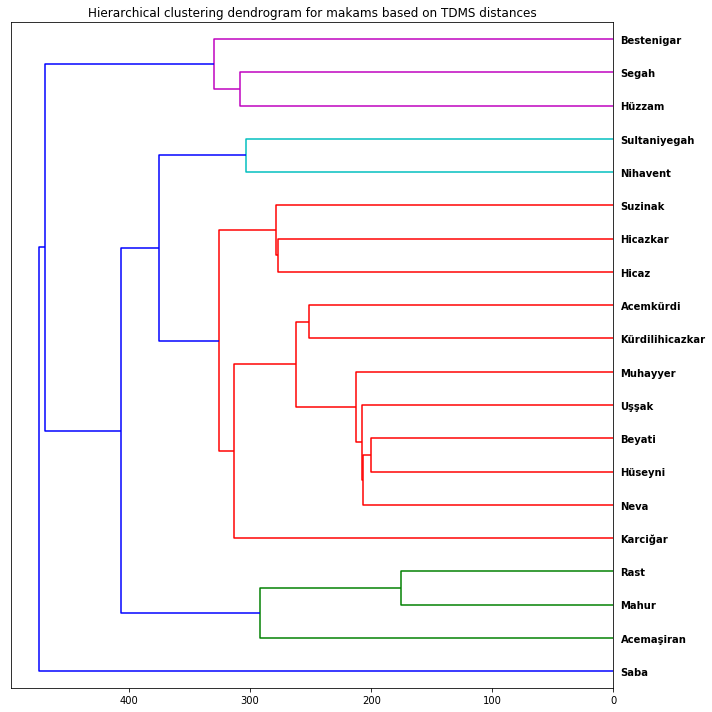

In [64]:
def _flatten_average_tdms_per_makam(av_data_by_makam):
        """Convert NxN TDMS feature per makam to MxN^2 required by
        scipy pdist implementation
        """
        flat_mat = np.concatenate(
            [
                data.reshape(1, -1)  # NxN -> 1xN^2 
                for data in av_data_by_makam.values()  # M makams
            ],
            axis=0  # MxN^2 
        )

        return flat_mat, list(av_data_by_makam.keys())

def compute_linkage(av_tdms_per_makam):
    flat_average_tdms, makam_labels = _flatten_average_tdms_per_makam(
        av_tdms_per_makam
    )
    
    condensed_tdms_dists = pdist(flat_average_tdms, "canberra")
    z = linkage(condensed_tdms_dists, optimal_ordering=True)
    
    return z, makam_labels

def plot_dendogram(z, makam_labels, save_path=None):
    plt.figure(figsize=(10, 10))
    
    makam_labels_turkish = [LABEL_DICT[m_lbl] for m_lbl in makam_labels]
    ax = dendrogram(z, labels=makam_labels_turkish, orientation='left')
    plt.title('Hierarchical clustering dendrogram for makams based on TDMS distances')
    plt.yticks(weight='bold', size='10')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig("dendrogram"+ '.pdf')
    plt.show()

plot_dendogram(
    *compute_linkage(average_tdms_per_makam)
)

# dist_all = []
# for i in range(len(dict.keys())):
#     for j in range(i + 1, len(dict.keys())):
#         dist_temp = []
#         for k in range(0, 1200):
#             dist_temp.append(pdist(np.vstack((average[i], np.roll(average[j],k, axis=0))),
#                       "canberra"))
#         dist_all.append(min(dist_temp)[0])
#
# z = linkage(np.array(dist_all), optimal_ordering=True)
# plt.figure(figsize=(9, 9))
# dendrogram(z, labels=np.array(modes), orientation='left')
# plt.title('Hierarchical clustering dendrogram for modes based on histogram'
#           ' distances')
# plt.yticks(weight='bold', size='10')
# plt.tight_layout()
# plt.savefig("dendrogram"+ '.pdf')
# plt.show()

In the dendogram, we can observe clusters:

1. Beyati, Hüseyni, Neva, Uşşak & Muhayyer
2. Rast & Mahur
3. Nihavent & Sultaniyegah
4. Hüzzam & Segah

Referring to the confusion matrices, they are also confused by ML models in general.

# Distance matrix

It's not ported from the notebook. I added it as an addition, in case we need it at some point.

Idea: maybe we can plot dist matrix and dendogram together?

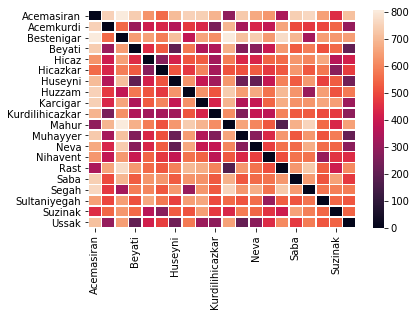

In [61]:
def compute_pairwise_dists(av_tdms_per_makam, metric="canberra"):
    flat_average_tdms, makam_labels = _flatten_average_tdms_per_makam(
        av_tdms_per_makam
    )
    
    pairwise_tdms_dists = cdist(flat_average_tdms, flat_average_tdms, metric)
    return pd.DataFrame(
        pairwise_tdms_dists,
        columns=makam_labels,
        index=makam_labels
    )

def plot_pairwise_dists(pairwise_dists):
    sns.heatmap(
        pairwise_dists,
        xticklabels=3,
        cbar=True,
        linewidths=0.5,
    )
    
plot_pairwise_dists(
    compute_pairwise_dists(average_tdms_per_makam)
)


# Cluster Purity

In [ ]:
from scipy.cluster.vq import vq, kmeans, kmeans2, whiten

def purity_score(clusters, classes):
    
    A = np.c_[(clusters,classes)]
    n_accurate = 0.

    for j in np.unique(A[:,0]):
        z = A[A[:,0] == j, 1]
        x = np.argmax(np.bincount(z))
        n_accurate += len(z[z == x])

    return n_accurate / A.shape[0] 

def clustering_scipy_kmeans(features, targets, n_clust = 20):
    whitened = features
    centroid, label = kmeans2(whitened, n_clust, minit = 'points')
#     for ii in range(2):
#         plt.subplot(1,2,ii+1)
#         plt.plot(centroid[ii])
#         plt.show()

    purity = purity_score(label.astype(int), targets)

    return label, purity

In [ ]:
def computePurityScore(label1, label2):
    sub_X = []
    sub_Y = []

    for item in hist_data:
        if hist_data[item][0][1] == label1 or hist_data[item][0][1] == label2:
            sub_X.append(hist_data[item][0][0])
            sub_Y.append(makam_label_map[hist_data[item][0][1]]) 

    label, purity = clustering_scipy_kmeans(sub_X, sub_Y, n_clust = 2)
    return label, purity

purity_score_matrix = []
for i in range(20):
    tmp = []
    for j in range(20):
        tmp.append(0)
    purity_score_matrix.append(tmp)

for i in range(20):
    for j in range(0, i):
        label, purity = computePurityScore(makam_number_map[i], makam_number_map[j])
        purity_score_matrix[i][j] = purity

        
print(purity_score_matrix)

In [ ]:
import pandas as pd
import seaborn as sn

label_dict = {u'Acemasiran': u'Acemaşiran',
              u'Acemkurdi': u'Acemkürdi',
              u'Bestenigar': u'Bestenigar',
              u'Beyati': u'Beyati',
              u'Hicaz': u'Hicaz',
              u'Hicazkar': u'Hicazkar',
              u'Huseyni': u'Hüseyni',
              u'Huzzam': u'Hüzzam',
              u'Karcigar': u'Karciğar',
              u'Kurdilihicazkar': u'Kürdilihicazkar',
              u'Mahur': u'Mahur',
              u'Muhayyer': u'Muhayyer',
              u'Neva': u'Neva',
              u'Nihavent': u'Nihavent',
              u'Rast': u'Rast',
              u'Saba': u'Saba',
              u'Segah': u'Segah',
              u'Sultaniyegah': u'Sultaniyegah',
              u'Suzinak': u'Suzinak',
              u'Ussak': u'Uşşak'}

x_labels = ['M'  + str(i) + ': ' + label_dict[l] 
            for (i, l) in enumerate(makam_label_map.keys())]
y_labels = ['M' + str(i) for i in range(len(x_labels))]

mat = []
for p in purity_score_matrix:
    mat.append(p)

mat = np.array(mat)

df_mat = pd.DataFrame(mat, columns=x_labels, index = y_labels)
plt.figure(figsize = (16,16))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_mat, cmap="gray", annot=True,annot_kws={"size": 10})# font size
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='left', rotation = 60)
ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
plt.savefig('pairwise_matrix.pdf')

# ROC

In [ ]:
def getDistanceBetweenHist(segment, method, metric, compression = -1):
    cnt = 0

    if method == 1:
        X = np.zeros((len(segment),len(segment)))
        for ii in range(len(segment)):
            for jj in range(len(segment)):
                X[ii,jj] = kldiv(segment[ii],segment[jj])

    if method == 2:
        d = pdist(segment, metric)
        X = squareform(d)

    if method == 3:
        X = np.zeros((len(segment),len(segment)))
        for ii in range(len(segment)):
            for jj in range(len(segment)):
                X[ii,jj] = Bhattacharya(segment[ii],segment[jj])

    if method == 4:
        X = np.zeros((len(segment),len(segment)))
        for ii in range(len(segment)):
            for jj in range(len(segment)):
                X[ii,jj] = jensen_shannon_divergence([segment[ii],segment[jj]])

    rank_order = np.argsort(X)

    X_norm = X/np.max(X)
    vectorized = np.reshape(X_norm, (len(X_norm)*len(X_norm),1))

    distances = []
    for ii in range(len(X)):
        for jj in range(int(len(X)/2)):
            distances.append(X_norm[jj,ii])

    max_within_class = np.max(distances[int((len(distances)/2)):])
    min_outside_class = np.min(distances[:int((len(distances)/2))])
    dispersion_1 =  min_outside_class / max_within_class

    distances = []
    for ii in range(len(X)):
        for jj in range(int(len(X)/2),len(X)):
            distances.append(X[jj,ii])

    max_within_class = np.max(distances[int((len(distances)/2)):])
    min_outside_class = np.min(distances[:int((len(distances)/2))])
    dispersion_2 =  min_outside_class / max_within_class
    
    dispersion = np.mean((dispersion_1,dispersion_2))

    return dispersion, rank_order, vectorized

In [ ]:
from dit.divergences import jensen_shannon_divergence

def kldiv(x, y):
    eps = np.finfo(float).eps*2*len(x)
    x = np.array(x)+eps
    y = np.array(y)+eps

    if x.size != y.size:
        print ("Arguments are of different length.")
        return np.NaN
    return (np.dot(x, np.log(x)-np.log(y))+np.dot(y, np.log(y)-np.log(x)))


def Bhattacharya(x, y):
    eps = np.finfo(float).eps*2*len(x)
    x = np.array(x)+eps
    y = np.array(y)+eps

    x = x/np.sum(x)
    y = y/np.sum(y)

    return -np.log(np.sum(np.sqrt(x*y)))

In [ ]:
def makeClasses(song_class_1,song_class_2):
    classes_1 = np.hstack([np.ones(song_class_1),np.zeros(song_class_2)]*song_class_1)
    classes_2 = np.hstack([np.zeros(song_class_1),np.ones(song_class_2)]*song_class_2)
    classes = np.hstack((classes_1,classes_2))
    classes = classes.reshape(len(classes),1)
    return classes

classes = makeClasses(50, 50)

from sklearn.metrics import roc_curve, auc

def getBinaryROC(vectorized,classes,label):
    mat = np.append(vectorized,classes,axis=1)
    #print mat

    fpr, tpr, threshold = roc_curve(mat[:,1], mat[:,0], pos_label=0)
    print(threshold)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    print(eer)

    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(mat[:,1], mat[:,0], pos_label=0)
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])    

    #plt.figure()
    lw = 2
    plt.plot(fpr["macro"], tpr["macro"], lw=lw, label= label + ', AUC = %0.2f, EER = %0.2f' % ((roc_auc["macro"]-.01), eer))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize = 22)
    plt.ylabel('True Positive Rate',fontsize = 22)
    plt.title('Svara count histogram',fontsize = 18)
    plt.legend(loc="lower right")
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.show()

In [ ]:
import itertools
from scipy.spatial.distance import pdist, squareform
def generateFigureROCFull(data_mat):

    labels = itertools.cycle(('corr', 'eucl', 'ctbl', 'bhat'))

    fig = plt.figure()
    fig.set_size_inches(6,5)
    fig.set_dpi(1200)

    method = 2
    metric = ['correlation', 'euclidean', 'cityblock']

    for ii in metric:
        dispersion, rank_order, vectorized = getDistanceBetweenHist(data_mat, method = method, metric = ii)
        getBinaryROC(vectorized,classes,next(labels))

    method = 3
    dispersion, rank_order, vectorized = getDistanceBetweenHist(data_mat, method = method, metric = 'euclidean')
    getBinaryROC(vectorized,classes,next(labels))

    # plt.show()
    plt.savefig("ROC.png", bbox_inches="tight")

In [ ]:
makam_label_map = {'Mahur':0, 'Acemkurdi':1, 'Nihavent':2, 'Sultaniyegah':3, 'Muhayyer':4, 'Huzzam':5, 'Karcigar':6, 'Saba':7, 'Segah':8, 'Suzinak':9, 'Kurdilihicazkar':10, 'Bestenigar':11, 'Neva':12, 'Hicaz':13, 'Ussak':14, 'Hicazkar':15, 'Huseyni':16, 'Acemasiran':17, 'Beyati':18, 'Rast':19}
makam_number_map = {0: 'Mahur', 1: 'Acemkurdi', 2: 'Nihavent', 3:'Sultaniyegah', 4:'Muhayyer', 5:'Huzzam', 6:'Karcigar', 7:'Saba', 8:'Segah', 9:'Suzinak', 10:'Kurdilihicazkar', 11:'Bestenigar', 12:'Neva', 13:'Hicaz', 14:'Ussak', 15:'Hicazkar', 16:'Huseyni', 17:'Acemasiran', 18:'Beyati', 19:'Rast'}

mahur = []
acem = []

for item in hist_data:
    if (hist_data[item][0][1] == 'Mahur'):
        mahur.append(hist_data[item][0][0])
    if (hist_data[item][0][1] == 'Acemkurdi'):
        acem.append(hist_data[item][0][0])
print(len(mahur), len(acem))

mahur_acem = []
for item in mahur:
    mahur_acem.append(item)
for item in acem:
    mahur_acem.append(item)
    
print(len(mahur_acem))

In [ ]:
generateFigureROCFull(mahur_acem)